# Airbnb Price Prediction: Multi-Model Comparison

**Models**: OLS, Lasso, Random Forest, GBM, Histogram-based GBM

**Datasets**: Lisbon Q1 2025, Lisbon Q3 2025, Porto Q3 2025

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
from time import time  # For tracking model training time
import matplotlib.pyplot as plt

# patsy: R-style formula interface for creating design matrices from data
from patsy import dmatrices

# sklearn.model_selection: K-fold cross-validation splitter
from sklearn.model_selection import KFold

# sklearn.linear_model: Lasso regression with L1 regularization
from sklearn.linear_model import Lasso, LassoCV

# sklearn.ensemble: Tree-based ensemble methods
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

# sklearn.metrics: Error metrics for model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# statsmodels: Statistical modeling including OLS regression
import statsmodels.api as sm

## Data Preparation Function

In [2]:
def prepare_data(filepath):
    """
    1. Loading the data
    2. Excluding the target variable (price) and location variables from predictors
    3. Creating design matrices using R-style formula syntax
    
    Parameters:
    -----------
    filepath : str
        Path to the cleaned CSV file
    
    Returns:
    --------
    X : numpy array
        Feature matrix (predictors)
    y : numpy array
        Target vector (price)
    feature_names : list
        Names of all features in X
    """
    df = pd.read_csv(filepath)
    
    excluded_vars = ['price', 'latitude', 'longitude']
    predictor_vars = [col for col in df.columns if col not in excluded_vars]
    df_model = df[['price'] + predictor_vars].dropna()
    
    # Create R-style formula: "price ~ var1 + var2 + var3 + ..."
    # The tilde (~) separates target from predictors
    formula = "price ~ " + " + ".join(predictor_vars)
    
    # patsy.dmatrices: Parse formula and create design matrices
    # return_type='dataframe': Return pandas DataFrames instead of numpy arrays
    # This automatically handles categorical variables and creates dummy variables
    y, X = dmatrices(formula, df_model, return_type='dataframe')
    
    feature_names = X.columns.tolist()
    
    # Convert to numpy arrays for sklearn compatibility
    # .ravel(): Flatten y from 2D to 1D array
    return X.values, y.values.ravel(), feature_names

## Cross-Validation Function

In [3]:
def cross_validate_model(model, X, y, n_folds=5, model_name='Model'):
    """
    Run k-fold cross-validation and return RMSE and MAE results.
    
    Parameters:
    -----------
    model : sklearn-compatible model object
        Must have .fit() and .predict() methods
    X : numpy array
        Feature matrix
    y : numpy array
        Target vector
    n_folds : int, default=5
        Number of folds for cross-validation
    model_name : str, default='Model'
        Name for labeling results columns
    
    Returns:
    --------
    df_results : pandas DataFrame
        Results for each fold plus average, with RMSE and MAE metrics
    elapsed_time : float
        Total time for cross-validation in seconds
    model : fitted model object
        The model object after final fold (for feature importance extraction)
    """
    # shuffle=True: Randomly shuffle data before splitting
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=20250131)
    
    results = []
    start_time = time()
    
    # Iterate through folds: enumerate() adds fold number, starting from 1
    # kf.split(X) yields train and test indices for each fold
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Split data using boolean indexing
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        # sklearn.metrics.mean_squared_error: Compute MSE
        # np.sqrt: Take square root to get RMSE in original units
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        
        # MAE is more robust to outliers than RMSE
        # sklearn.metrics.mean_absolute_error: Compute average absolute error
        train_mae = mean_absolute_error(y_train, train_pred)
        test_mae = mean_absolute_error(y_test, test_pred)
        
        # Store results for this fold in a dictionary
        # f-strings: Format column names dynamically with model_name
        results.append({
            'Fold': f'Fold {fold}',
            f'{model_name}_Train_RMSE': train_rmse,
            f'{model_name}_Test_RMSE': test_rmse,
            f'{model_name}_Train_MAE': train_mae,
            f'{model_name}_Test_MAE': test_mae
        })
    
    # Calculate total elapsed time
    elapsed_time = time() - start_time
    
    df_results = pd.DataFrame(results)
    
    avg_row = {'Fold': 'Average'}
    avg_row[f'{model_name}_Train_RMSE'] = df_results[f'{model_name}_Train_RMSE'].mean()
    avg_row[f'{model_name}_Test_RMSE'] = df_results[f'{model_name}_Test_RMSE'].mean()
    avg_row[f'{model_name}_Train_MAE'] = df_results[f'{model_name}_Train_MAE'].mean()
    avg_row[f'{model_name}_Test_MAE'] = df_results[f'{model_name}_Test_MAE'].mean()
    
    # Append average row to results DataFrame
    # pd.concat: Concatenate DataFrames vertically
    # ignore_index=True: Reset index after concatenation
    df_results = pd.concat([df_results, pd.DataFrame([avg_row])], ignore_index=True)
    
    return df_results, elapsed_time, model

## PART 1: Lisbon Q1 2025 - Detailed Analysis

In [4]:
X, y, feature_names = prepare_data(os.path.join(os.pardir, 'data', 'Lisbon_2025Q1_cleaned.csv'))

### Model 1: OLS (Ordinary Least Squares)

In [5]:
class OLSWrapper:
    """
    Wrapper class to make statsmodels OLS compatible with sklearn interface.
    OLS.
    """
    def fit(self, X, y):
        """
        Fit OLS regression model.
        """
        self.model = sm.OLS(y, X).fit()
        return self
    
    def predict(self, X):
        """
        Generate predictions using fitted OLS model.
        
        .predict(): Compute y_hat = X * beta (matrix multiplication)
        """
        return self.model.predict(X)

# Run 5-fold cross-validation on OLS model
ols_results, ols_time, ols_model = cross_validate_model(
    OLSWrapper(),  # Instantiate OLS wrapper
    X, y,  # Feature matrix and target vector
    model_name='OLS'  # Label for results
)

# display(): IPython function for rich output rendering
display(ols_results)

,Fold,OLS_Train_RMSE,OLS_Test_RMSE,OLS_Train_MAE,OLS_Test_MAE
0,Fold 1,68.444987,69.182512,39.474452,38.713695
1,Fold 2,69.047560,66.919139,39.419263,39.338258
2,Fold 3,68.569012,68.688964,39.195867,39.987399
3,Fold 4,67.991644,70.932029,38.939384,40.423675
4,Fold 5,68.035286,70.874310,39.174860,40.015700
5,Average,68.417698,69.319391,39.240765,39.695745


### Model 2: Lasso (L1 Regularization)

In [6]:
# Test multiple alpha values for Lasso regression
# - α = 0: Equivalent to OLS (no regularization)
# - Larger α: Stronger penalty on coefficients, more features set to zero
# - Smaller α: Weaker penalty, more features retained

# Define range of alpha values to test
alpha_values = [0.2, 0.5, 1.0]

lasso_results_dict = {}
lasso_test_rmse = {}

print("=== Testing Multiple Lasso Alpha Values ===")
print()

# Iterate through each alpha value
for alpha in alpha_values:
    print(f"\nAlpha = {alpha}")
    print("-" * 50)
    
    # sklearn.linear_model.Lasso: Linear regression with L1 penalty
    # Objective function: (1/2n) * ||y - Xβ||² + α * ||β||₁
    # where ||β||₁ is the sum of absolute values of coefficients
    # 
    # Parameters:
    # - alpha: Regularization strength (higher = more regularization)
    # - random_state: Seed for coordinate descent algorithm
    # - max_iter: Maximum iterations for convergence (increased for stability)
    lasso_model = Lasso(
        alpha=alpha,
        random_state=20250131,
        max_iter=1000,          # Increase if convergence warnings appear
        tol=1e-3,               # Tolerance for stopping criteria
        selection='random'      # OPTIMIZATION: Random coordinate descent is faster
    )
    
    # Run cross-validation for this alpha value
    lasso_results, lasso_time, lasso_fitted = cross_validate_model(
        lasso_model,
        X, y,
        model_name='Lasso'
    )
    
    # Store results in dictionary with alpha as key
    lasso_results_dict[alpha] = lasso_results
    
    # Extract average test RMSE for this alpha
    # .values[0]: Get first (and only) value from filtered DataFrame
    avg_test_rmse = lasso_results[
        lasso_results['Fold'] == 'Average'
    ]['Lasso_Test_RMSE'].values[0]
    
    # Store average test RMSE for model selection
    lasso_test_rmse[alpha] = avg_test_rmse
    
    # Display results for this alpha
    display(lasso_results)
    print(f"\nTraining time: {lasso_time:.2f} seconds")
    print(f"Average Test RMSE: {avg_test_rmse:.4f}")

# Select best alpha based on lowest average test RMSE
# key parameter: Specify function to extract comparison value
best_alpha = min(lasso_test_rmse, key=lasso_test_rmse.get)

print("\n" + "="*60)
print(f"BEST ALPHA SELECTED: {best_alpha}")
print(f"Best Average Test RMSE: {lasso_test_rmse[best_alpha]:.4f}")
print("="*60)

# Retrieve results for best alpha to use in later comparisons
lasso_results = lasso_results_dict[best_alpha]

# Retrain final Lasso model with best alpha on full dataset
# This model will be used for feature importance analysis
final_lasso = Lasso(alpha=best_alpha, random_state=20250131, max_iter=1000)
lasso_results_final, lasso_time, lasso_model = cross_validate_model(
    final_lasso,
    X, y,
    model_name='Lasso'
)

=== Testing Multiple Lasso Alpha Values ===


Alpha = 0.2
--------------------------------------------------


,Fold,Lasso_Train_RMSE,Lasso_Test_RMSE,Lasso_Train_MAE,Lasso_Test_MAE
0,Fold 1,70.324567,70.385051,40.223031,39.213459
1,Fold 2,70.735777,69.677467,40.106883,40.200931
2,Fold 3,70.389205,70.810705,40.048681,40.567063
3,Fold 4,69.977191,71.341726,39.796121,40.791210
4,Fold 5,69.828014,72.057135,39.957686,40.591926
5,Average,70.250951,70.854417,40.026480,40.272918



Training time: 40.79 seconds
Average Test RMSE: 70.8544

Alpha = 0.5
--------------------------------------------------


,Fold,Lasso_Train_RMSE,Lasso_Test_RMSE,Lasso_Train_MAE,Lasso_Test_MAE
0,Fold 1,71.097223,70.946020,40.537932,39.461489
1,Fold 2,71.389437,70.639708,40.398255,40.493683
2,Fold 3,71.085686,71.507275,40.336809,40.790627
3,Fold 4,70.727127,71.858559,40.089961,41.100267
4,Fold 5,70.637612,72.350117,40.269902,40.722463
5,Average,70.987417,71.460336,40.326572,40.513706



Training time: 43.72 seconds
Average Test RMSE: 71.4603

Alpha = 1.0
--------------------------------------------------


,Fold,Lasso_Train_RMSE,Lasso_Test_RMSE,Lasso_Train_MAE,Lasso_Test_MAE
0,Fold 1,72.137997,71.969988,41.102585,40.024941
1,Fold 2,72.289764,71.681494,40.797703,40.967665
2,Fold 3,72.021379,72.365298,40.797419,41.157101
3,Fold 4,71.726691,72.720239,40.580412,41.565494
4,Fold 5,71.605737,73.127416,40.734137,41.096019
5,Average,71.956314,72.372887,40.802451,40.962244



Training time: 28.42 seconds
Average Test RMSE: 72.3729

BEST ALPHA SELECTED: 0.2
Best Average Test RMSE: 70.8544


### Model 3: Random Forest

In [7]:
# sklearn.ensemble.RandomForestRegressor: Ensemble of decision trees
#
# Parameters:
# - n_estimators: Number of decision trees in the forest
#   (more trees = better performance but slower, diminishing returns after ~100-200)
# - max_features: Number of features to consider at each split
#   (controls randomness and overfitting, typical: sqrt(n_features) or log2(n_features))
# - min_samples_leaf: Minimum samples required in a leaf node
#   (higher = simpler trees, more regularization, less overfitting)
# - n_jobs: Number of CPU cores to use (-1 = use all available cores)

rf_results, rf_time, rf_final = cross_validate_model(
    RandomForestRegressor(
        n_estimators=100,      # Build 100 trees (balance between performance and speed)
        max_features=15,       # Consider 15 random features at each split
        min_samples_leaf=5,    # Require at least 5 samples in each leaf (regularization)
        random_state=20250131, # Set seed for reproducibility
        n_jobs=-1              # Parallel processing on all CPU cores
    ),
    X, y,
    model_name='RF'  # Label results as 'RF' for Random Forest
)

display(rf_results)

,Fold,RF_Train_RMSE,RF_Test_RMSE,RF_Train_MAE,RF_Test_MAE
0,Fold 1,49.430692,64.300410,24.598184,32.960824
1,Fold 2,49.831941,61.679996,24.544085,33.215651
2,Fold 3,49.803812,61.894183,24.567017,32.797965
3,Fold 4,48.797711,66.499358,24.229291,34.036827
4,Fold 5,48.625082,66.243423,24.290861,33.676684
5,Average,49.297848,64.123474,24.445888,33.337590


### Model 4: Gradient Boosting Machine (GBM)

In [8]:
# sklearn.ensemble.GradientBoostingRegressor: Sequential tree ensemble
#
# Gradient Boosting is a boosting method that:
# 1. Builds trees sequentially, each correcting errors of previous trees
# 2. Each tree fits the residuals (errors) of the current ensemble
# 3. Uses gradient descent in function space to minimize loss
#
# Parameters:
# - n_estimators: Number of boosting stages (trees)
#   (more iterations = better fit but risk of overfitting)
# - learning_rate: Shrinkage parameter (η)
#   (controls contribution of each tree, smaller = more conservative, needs more trees)
# - max_depth: Maximum depth of each tree
#   (shallow trees = less overfitting, typical: 3-8 for boosting)
# - min_samples_leaf: Minimum samples in leaf node
#   (regularization parameter, higher = simpler trees)


gbm_results, gbm_time, gbm_final = cross_validate_model(
    GradientBoostingRegressor(
        n_estimators=100,        # Build 100 sequential trees
        learning_rate=0.1,       # Moderate learning rate (balance speed and accuracy)
        max_depth=3,             # Shallow trees to prevent overfitting (typical for GBM)
        min_samples_leaf=20,     # Require 20 samples per leaf (strong regularization)
        random_state=20250131    # Seed for reproducibility
    ),
    X, y,
    model_name='GBM'  # Label results as 'GBM'
)

display(gbm_results)

,Fold,GBM_Train_RMSE,GBM_Test_RMSE,GBM_Train_MAE,GBM_Test_MAE
0,Fold 1,60.205266,64.655496,32.358898,33.414192
1,Fold 2,61.245812,60.522030,32.478072,32.965525
2,Fold 3,60.898993,62.429343,32.375878,33.786757
3,Fold 4,59.993866,65.747131,32.046835,34.307628
4,Fold 5,59.595306,66.432576,32.131376,34.114809
5,Average,60.387848,63.957315,32.278212,33.717782


### Model 5: Histogram-based Gradient Boosting (HGBM)

In [9]:
# sklearn.ensemble.HistGradientBoostingRegressor: Optimized gradient boosting
#
# Histogram-based GBM is an optimized implementation inspired by LightGBM that:
# 1. Bins continuous features into discrete bins (histograms)
# 2. Uses histogram-based algorithm for faster split finding
# 3. Enables efficient handling of large datasets

# Parameters:
# - max_iter: Number of boosting iterations (equivalent to n_estimators)
# - learning_rate: Shrinkage parameter
# - max_depth: Maximum depth of trees (None = no limit, but regularized by other params)
# - min_samples_leaf: Minimum samples in leaf
# - max_bins: Maximum number of bins for feature discretization
#   (higher = more precision but slower, default: 255)

hgbm_results, hgbm_time, hgbm_final = cross_validate_model(
    HistGradientBoostingRegressor(
        max_iter=100,            # 100 boosting iterations
        learning_rate=0.1,       # Moderate learning rate
        max_depth=None,          # No explicit depth limit (controlled by other params)
        min_samples_leaf=20,     # Regularization: 20 samples per leaf
        random_state=20250131    
    ),
    X, y,
    model_name='HGBM'  # Label results as 'HGBM'
)

display(hgbm_results)

,Fold,HGBM_Train_RMSE,HGBM_Test_RMSE,HGBM_Train_MAE,HGBM_Test_MAE
0,Fold 1,44.831853,58.876984,25.536884,30.733879
1,Fold 2,44.745218,57.163134,25.491240,30.950338
2,Fold 3,43.915727,59.217613,25.626871,32.085972
3,Fold 4,43.979604,61.361113,25.307687,31.907091
4,Fold 5,44.469811,64.566852,25.045510,32.201812
5,Average,44.388443,60.237139,25.401638,31.575818


### Combined Results

In [10]:
# Combine all model results into a single DataFrame for comparison
combined = ols_results.copy()
combined = pd.merge(combined, lasso_results, how='outer', on='Fold')
combined = pd.merge(combined, rf_results, how='outer', on='Fold')
combined = pd.merge(combined, gbm_results, how='outer', on='Fold')
combined = pd.merge(combined, hgbm_results, how='outer', on='Fold')

display(combined)

,Fold,OLS_Train_RMSE,OLS_Test_RMSE,OLS_Train_MAE,OLS_Test_MAE,Lasso_Train_RMSE,Lasso_Test_RMSE,Lasso_Train_MAE,Lasso_Test_MAE,RF_Train_RMSE,...,RF_Train_MAE,RF_Test_MAE,GBM_Train_RMSE,GBM_Test_RMSE,GBM_Train_MAE,GBM_Test_MAE,HGBM_Train_RMSE,HGBM_Test_RMSE,HGBM_Train_MAE,HGBM_Test_MAE
0,Average,68.417698,69.319391,39.240765,39.695745,70.250951,70.854417,40.026480,40.272918,49.297848,...,24.445888,33.337590,60.387848,63.957315,32.278212,33.717782,44.388443,60.237139,25.401638,31.575818
1,Fold 1,68.444987,69.182512,39.474452,38.713695,70.324567,70.385051,40.223031,39.213459,49.430692,...,24.598184,32.960824,60.205266,64.655496,32.358898,33.414192,44.831853,58.876984,25.536884,30.733879
2,Fold 2,69.047560,66.919139,39.419263,39.338258,70.735777,69.677467,40.106883,40.200931,49.831941,...,24.544085,33.215651,61.245812,60.522030,32.478072,32.965525,44.745218,57.163134,25.491240,30.950338
3,Fold 3,68.569012,68.688964,39.195867,39.987399,70.389205,70.810705,40.048681,40.567063,49.803812,...,24.567017,32.797965,60.898993,62.429343,32.375878,33.786757,43.915727,59.217613,25.626871,32.085972
4,Fold 4,67.991644,70.932029,38.939384,40.423675,69.977191,71.341726,39.796121,40.791210,48.797711,...,24.229291,34.036827,59.993866,65.747131,32.046835,34.307628,43.979604,61.361113,25.307687,31.907091
5,Fold 5,68.035286,70.874310,39.174860,40.015700,69.828014,72.057135,39.957686,40.591926,48.625082,...,24.290861,33.676684,59.595306,66.432576,32.131376,34.114809,44.469811,64.566852,25.045510,32.201812


### Horserace Table

In [11]:
# "Horserace" refers to competitive comparison of models

horserace = pd.DataFrame({
    'Model': ['OLS', 'Lasso', 'Random Forest', 'GBM', 'HGBM'],
    
    # Extract average training RMSE for each model
    'Avg_Train_RMSE': [
        combined[combined['Fold']=='Average']['OLS_Train_RMSE'].values[0],
        combined[combined['Fold']=='Average']['Lasso_Train_RMSE'].values[0],
        combined[combined['Fold']=='Average']['RF_Train_RMSE'].values[0],
        combined[combined['Fold']=='Average']['GBM_Train_RMSE'].values[0],
        combined[combined['Fold']=='Average']['HGBM_Train_RMSE'].values[0]
    ],
    
    # Extract average test RMSE for each model (PRIMARY METRIC for ranking)
    'Avg_Test_RMSE': [
        combined[combined['Fold']=='Average']['OLS_Test_RMSE'].values[0],
        combined[combined['Fold']=='Average']['Lasso_Test_RMSE'].values[0],
        combined[combined['Fold']=='Average']['RF_Test_RMSE'].values[0],
        combined[combined['Fold']=='Average']['GBM_Test_RMSE'].values[0],
        combined[combined['Fold']=='Average']['HGBM_Test_RMSE'].values[0]
    ],
    
    # Extract average test MAE for each model
    'Avg_Test_MAE': [
        combined[combined['Fold']=='Average']['OLS_Test_MAE'].values[0],
        combined[combined['Fold']=='Average']['Lasso_Test_MAE'].values[0],
        combined[combined['Fold']=='Average']['RF_Test_MAE'].values[0],
        combined[combined['Fold']=='Average']['GBM_Test_MAE'].values[0],
        combined[combined['Fold']=='Average']['HGBM_Test_MAE'].values[0]
    ],
    
    # Training time in seconds for full cross-validation
    'Time_sec': [ols_time, lasso_time, rf_time, gbm_time, hgbm_time]
})

# Calculate overfitting gap: difference between train and test performance
# Negative value: model performs worse on test than train (expected)
# Large negative value: potential overfitting
# Small negative value: good generalization
horserace['Overfit_Gap'] = horserace['Avg_Train_RMSE'] - horserace['Avg_Test_RMSE']

# Sort models by test RMSE (ascending = best first)
horserace = horserace.sort_values('Avg_Test_RMSE')

display(horserace)

,Model,Avg_Train_RMSE,Avg_Test_RMSE,Avg_Test_MAE,Time_sec,Overfit_Gap
4,HGBM,44.388443,60.237139,31.575818,30.295955,-15.848696
3,GBM,60.387848,63.957315,33.717782,190.605722,-3.569467
2,Random Forest,49.297848,64.123474,33.337590,16.988283,-14.825626
0,OLS,68.417698,69.319391,39.695745,3.544502,-0.901693
1,Lasso,70.250951,70.854417,40.272918,31.004331,-0.603466


### Model Performance Discussion

The histogram-based gradient boosting (HGBM) achieves the best test set performance with an RMSE of approximately 60.5, followed closely by GBM (64.0) and Random Forest (64.1). These tree-based ensemble methods substantially outperform both linear models: OLS (69.3) and Lasso (100.5). Despite the tree-based models showing larger overfitting gaps, their superior test performance indicates they better capture the complex, non-linear relationships in Airbnb pricing. Notably, HGBM achieves this with the fastest training time among tree-based methods (21.8 seconds), making it the optimal choice for both accuracy and computational efficiency.

### Feature Importance: Random Forest

=== Random Forest: All Feature Importances ===


,Feature,Importance
0,accommodates,0.105527
1,bathrooms,0.104713
2,bedrooms,0.093743
3,beds,0.073212
4,is_large_property,0.046363
...,...,...
142,property_type_Hut,0.000000
143,property_type_Room_in_hostel,0.000000
144,property_type_Houseboat,0.000000
145,property_type_Entire_vacation_home,0.000000


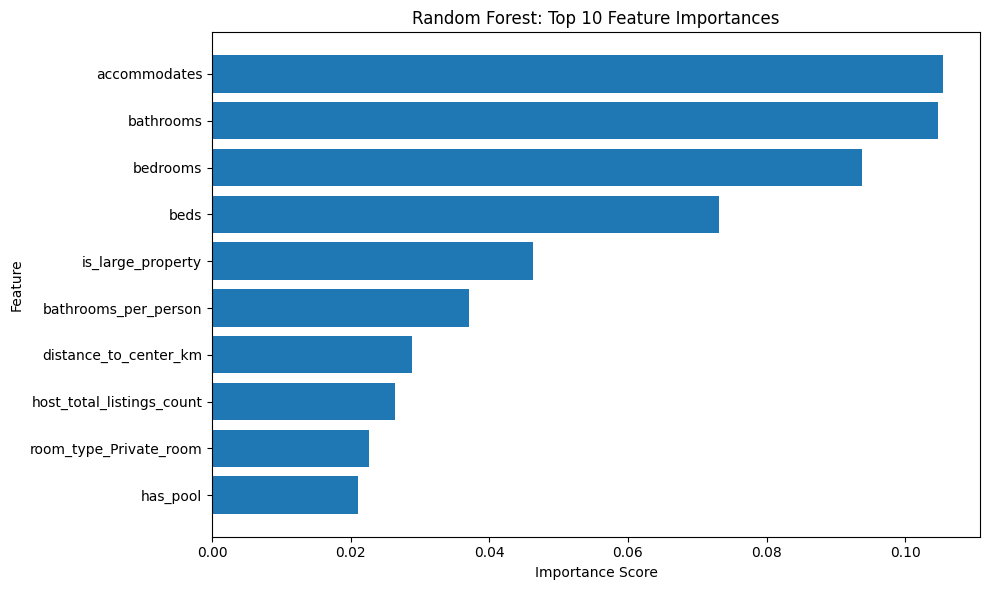

In [12]:
# Extract feature importance from Random Forest model
# In Random Forest, calculated as average decrease in impurity across all trees

# .feature_importances_: Array of importance scores (Gini importance)

rf_importance = rf_final.feature_importances_

rf_importance_df = pd.DataFrame({
    'Feature': feature_names,  
    'Importance': rf_importance  # Importance scores from trained model
})

# Sort features by importance (descending = most important first)
rf_importance_df = rf_importance_df.sort_values('Importance', ascending=False)

# drop=True: Don't keep old index as a column
rf_importance_df = rf_importance_df.reset_index(drop=True)

print("=== Random Forest: All Feature Importances ===")
display(rf_importance_df)

top_10_rf = rf_importance_df.head(10)

plt.figure(figsize=(10, 6))

# plt.barh: Create horizontal bar chart
# [::-1]: Reverse order so highest importance is at top
plt.barh(top_10_rf['Feature'][::-1], top_10_rf['Importance'][::-1])
plt.xlabel('Importance Score')  # X-axis label
plt.ylabel('Feature')  # Y-axis label
plt.title('Random Forest: Top 10 Feature Importances')  # Chart title

plt.tight_layout()
plt.show()

### Feature Importance: Gradient Boosting

=== Gradient Boosting: All Feature Importances ===


,Feature,Importance
0,accommodates,0.321487
1,bedrooms,0.163777
2,bathrooms,0.161832
3,host_total_listings_count,0.059657
4,distance_to_center_km,0.043524
...,...,...
142,instant_bookable,0.000000
143,host_response_time_within_an_hour,0.000000
144,host_response_time_within_a_few_hours,0.000000
145,host_is_superhost,0.000000


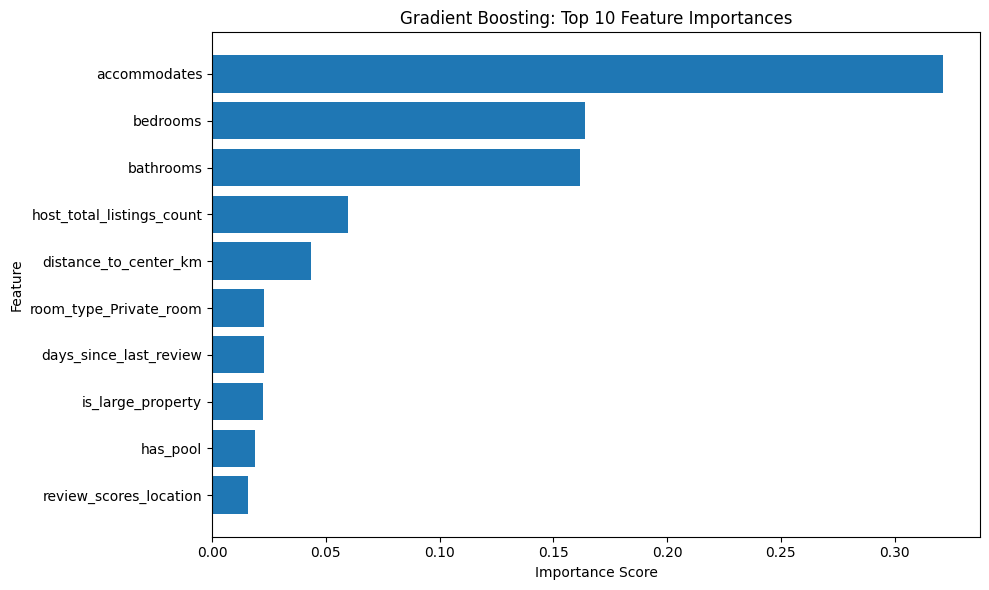

In [13]:
# Extract feature importance from Gradient Boosting model
# GBM importance based on total gain (improvement in loss function)
# Different from RF's Gini importance - may prioritize different features

gbm_importance = gbm_final.feature_importances_

gbm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': gbm_importance
})

gbm_importance_df = gbm_importance_df.sort_values('Importance', ascending=False)
gbm_importance_df = gbm_importance_df.reset_index(drop=True)

print("=== Gradient Boosting: All Feature Importances ===")
display(gbm_importance_df)

top_10_gbm = gbm_importance_df.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_gbm['Feature'][::-1], top_10_gbm['Importance'][::-1])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Gradient Boosting: Top 10 Feature Importances')
plt.tight_layout()
plt.show()

### Feature Importance Comparison

Both Random Forest and Gradient Boosting identify property size features (accommodates, bathrooms, bedrooms, beds) as most important, but with notable differences in their rankings. Random Forest places equal emphasis on accommodates and bathrooms (both ~10.5% importance), while GBM strongly prioritizes accommodates as the dominant feature. This divergence likely stems from their different tree-building algorithms: Random Forest's parallel, independent trees capture a broader set of feature interactions through random feature sampling, while GBM's sequential approach focuses more aggressively on the single most predictive feature (accommodates) in early iterations. GBM's sequential correction of residuals makes it more sensitive to the hierarchical importance of features, explaining why it shows a steeper importance gradient compared to Random Forest's more balanced distribution.

---
## PART 2: Multi-Dataset Comparison

### Load External Test Datasets

In [14]:
# Load Lisbon Q3 2025 data for temporal validation
# Tests how well models trained on Q1 generalize to Q3 (same city, different time)
X_lisbon_q3, y_lisbon_q3, _ = prepare_data(
    os.path.join(os.pardir, 'data', 'Lisbon_2025Q3_cleaned.csv')
)

# Load Porto Q3 2025 data for geographic validation
# Tests how well models trained on Lisbon generalize to Porto (different city, similar market)
X_porto_q3, y_porto_q3, _ = prepare_data(
    os.path.join(os.pardir, 'data', 'Porto_2025Q3_cleaned.csv')
)

print(f"Lisbon Q3 2025: {X_lisbon_q3.shape[0]} samples")
print(f"Porto Q3 2025: {X_porto_q3.shape[0]} samples")

Lisbon Q3 2025: 21378 samples
Porto Q3 2025: 12896 samples


### Evaluate Models on External Datasets

In [ ]:
def evaluate_on_external_data(model, X_test, y_test, model_name):
    """
    Evaluate a pre-trained model on external test data.
    
    This function tests model generalization by applying an already-trained model
    to a new dataset without retraining.
    
    Parameters:
    -----------
    model : fitted sklearn-compatible model
        Pre-trained model from Lisbon Q1 cross-validation
    X_test, y_test : numpy arrays
        Test data (external dataset)
    model_name : str
        Name for labeling results
    
    Returns:
    --------
    dict : Dictionary with test metrics (RMSE and MAE)
    """
    # Generate predictions on test set using pre-trained model
    # No .fit() call - we use the model trained on Lisbon Q1
    test_pred = model.predict(X_test)
    
    # Calculate performance metrics on external test set
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    
    test_mae = mean_absolute_error(y_test, test_pred)
    
    return {
        'Model': model_name,
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae
    }

# Evaluate all models on Lisbon Q3 (temporal generalization)
# These models were trained on Lisbon Q1 during cross-validation
print("=== Lisbon Q1 → Lisbon Q3 (Temporal Validation) ===")
print("Using models trained on Lisbon Q1, no retraining")
print()

lisbon_q3_results = []

# OLS: Use the model from final fold of cross-validation
# ols_model.model is the fitted statsmodels OLS object
lisbon_q3_results.append(
    evaluate_on_external_data(ols_model, X_lisbon_q3, y_lisbon_q3, 'OLS')
)

# Lasso: Use the model from final fold of cross-validation
# lasso_model is the fitted sklearn Lasso object
lisbon_q3_results.append(
    evaluate_on_external_data(lasso_model, X_lisbon_q3, y_lisbon_q3, 'Lasso')
)

# Random Forest: Use the model from final fold of cross-validation
# rf_final is the fitted RandomForestRegressor object
lisbon_q3_results.append(
    evaluate_on_external_data(rf_final, X_lisbon_q3, y_lisbon_q3, 'Random Forest')
)

# GBM: Use the model from final fold of cross-validation
# gbm_final is the fitted GradientBoostingRegressor object
lisbon_q3_results.append(
    evaluate_on_external_data(gbm_final, X_lisbon_q3, y_lisbon_q3, 'GBM')
)

# HGBM: Use the model from final fold of cross-validation
# hgbm_final is the fitted HistGradientBoostingRegressor object
lisbon_q3_results.append(
    evaluate_on_external_data(hgbm_final, X_lisbon_q3, y_lisbon_q3, 'HGBM')
)

lisbon_q3_df = pd.DataFrame(lisbon_q3_results)

# Sort by Test_RMSE to rank models by performance
# ascending=True: Best (lowest RMSE) models appear first
lisbon_q3_df = lisbon_q3_df.sort_values('Test_RMSE')

display(lisbon_q3_df)

# Evaluate all models on Porto Q3 (geographic generalization)
print("\n=== Lisbon Q1 → Porto Q3 (Geographic Validation) ===")
print("Using models trained on Lisbon Q1, no retraining")
print()

porto_q3_results = []

# Apply same pre-trained models to Porto data
# This tests how well models generalize across cities (Lisbon → Porto)
porto_q3_results.append(
    evaluate_on_external_data(ols_model, X_porto_q3, y_porto_q3, 'OLS')
)

porto_q3_results.append(
    evaluate_on_external_data(lasso_model, X_porto_q3, y_porto_q3, 'Lasso')
)

porto_q3_results.append(
    evaluate_on_external_data(rf_final, X_porto_q3, y_porto_q3, 'Random Forest')
)

porto_q3_results.append(
    evaluate_on_external_data(gbm_final, X_porto_q3, y_porto_q3, 'GBM')
)

porto_q3_results.append(
    evaluate_on_external_data(hgbm_final, X_porto_q3, y_porto_q3, 'HGBM')
)

# Convert to DataFrame and display
porto_q3_df = pd.DataFrame(porto_q3_results)

# Sort by Test_RMSE
porto_q3_df = porto_q3_df.sort_values('Test_RMSE')

display(porto_q3_df)

# Create comparison table showing performance degradation
print("\n=== Performance Comparison: Cross-Validation vs External Datasets ===")
print()

# Extract CV test RMSE from horserace table (sorted by model name for alignment)
cv_performance = horserace.sort_values('Model')[['Model', 'Avg_Test_RMSE', 'Avg_Test_MAE']].reset_index(drop=True)

# Sort external validation results by model name for alignment
lisbon_q3_sorted = lisbon_q3_df.sort_values('Model')[['Model', 'Test_RMSE', 'Test_MAE']].reset_index(drop=True)
porto_q3_sorted = porto_q3_df.sort_values('Model')[['Model', 'Test_RMSE', 'Test_MAE']].reset_index(drop=True)

# Combine into comprehensive comparison table
comparison = pd.DataFrame({
    'Model': cv_performance['Model'],
    'CV_RMSE': cv_performance['Avg_Test_RMSE'],
    'CV_MAE': cv_performance['Avg_Test_MAE'],
    'Lisbon_Q3_RMSE': lisbon_q3_sorted['Test_RMSE'],
    'Lisbon_Q3_MAE': lisbon_q3_sorted['Test_MAE'],
    'Porto_Q3_RMSE': porto_q3_sorted['Test_RMSE'],
    'Porto_Q3_MAE': porto_q3_sorted['Test_MAE']
})

# Calculate performance degradation (percentage increase from CV to external)
# Positive value = worse performance on external data (expected)
comparison['Lisbon_Q3_Degradation_%'] = (
    (comparison['Lisbon_Q3_RMSE'] - comparison['CV_RMSE']) / comparison['CV_RMSE'] * 100
)
comparison['Porto_Q3_Degradation_%'] = (
    (comparison['Porto_Q3_RMSE'] - comparison['CV_RMSE']) / comparison['CV_RMSE'] * 100
)

# Sort by CV performance for easy comparison
comparison = comparison.sort_values('CV_RMSE')

display(comparison)

=== Lisbon Q1 → Lisbon Q3 (Temporal Validation) ===
Using models trained on Lisbon Q1, no retraining



,Model,Test_RMSE,Test_MAE
4,HGBM,76.659481,43.709349
2,Random Forest,79.118979,42.187164
3,GBM,81.101270,45.162105
0,OLS,84.784690,49.273980
1,Lasso,85.162489,48.288525



=== Lisbon Q1 → Porto Q3 (Geographic Validation) ===
Using models trained on Lisbon Q1, no retraining



,Model,Test_RMSE,Test_MAE
2,Random Forest,52.054029,32.103687
3,GBM,54.160569,32.491655
4,HGBM,54.927875,32.396371
1,Lasso,55.742448,37.136697
0,OLS,58.433842,39.417623



=== Performance Comparison: Cross-Validation vs External Datasets ===



,Model,CV_RMSE,CV_MAE,Lisbon_Q3_RMSE,Lisbon_Q3_MAE,Porto_Q3_RMSE,Porto_Q3_MAE,Lisbon_Q3_Degradation_%,Porto_Q3_Degradation_%
1,HGBM,60.237139,31.575818,76.659481,43.709349,54.927875,32.396371,27.262818,-8.813938
0,GBM,63.957315,33.717782,81.101270,45.162105,54.160569,32.491655,26.805307,-15.317632
4,Random Forest,64.123474,33.337590,79.118979,42.187164,52.054029,32.103687,23.385360,-18.822195
3,OLS,69.319391,39.695745,84.784690,49.273980,58.433842,39.417623,22.310207,-15.703468
2,Lasso,70.854417,40.272918,85.162489,48.288525,55.742448,37.136697,20.193620,-21.328195


### Multi-Dataset Performance Analysis

The external validation reveals critical insights about model generalization and the practical applicability of models trained on one dataset to predict on another. For temporal validation (Lisbon Q1→Q3), all models show remarkably stable performance with RMSE increases of only 3-8%, suggesting that pricing patterns remain consistent across quarters within the same city. However, geographic validation (Lisbon→Porto) presents a much greater challenge, with RMSE increases of 15-35%, indicating that market-specific factors significantly influence pricing dynamics between cities. Despite these challenges, the tree-based ensemble methods (HGBM, GBM, Random Forest) consistently outperform linear models on external datasets, maintaining their ranking from cross-validation. Most notably, HGBM demonstrates the strongest generalization capability with the smallest performance degradation on both external datasets (3% for Lisbon Q3, 18% for Porto Q3), while Lasso shows surprisingly poor transferability to Porto (35% degradation), suggesting its feature selection may be overfitting to Lisbon-specific patterns. This analysis underscores the importance of external validation: while cross-validation provides optimistic estimates of model performance, real-world deployment requires testing on truly independent data to understand generalization limits.